# DataSet1 - Cleveland Heart Disease Prediction

## Table of Contents
1. [Introduction](#introduction)  
2. [Data Exploration & Preprocessing](#eda-preproc)  
3. [Models & Methodology](#models-methodology)  
4. [Results](#results)  
5. [Discussion](#discussion)  
6. [Conclusion](#conclusion)  
7. [Appendix](#appendix)


## 1) Introduction <a id='introduction'></a>

**Goal:** Predict the **presence of heart disease** (binary classification) using the **UCI Cleveland Heart Disease** dataset, and compare the performance of five machine learning models: **Logistic Regression**, **Random Forest**, **SVM (RBF)**, **KNN**, and **Decision Tree**.


This open dataset is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) and contains **303 observations** with **13 features**. 
 
The objective of this project is to build, tune, and evaluate these models to assess their effectiveness in predicting heart disease.

**Deliverables:**  
- A **comprehensive exploratory data analysis (EDA)**  
- A **clear preprocessing pipeline** using imputation, encoding, and scaling  
- Implementation of **five baseline models** (Logistic Regression, Random Forest, SVM, KNN, Decision Tree)    
- **Hyperparameter tuning** via 5-fold cross-validation  
- **Unified evaluation** on a held-out test set (Accuracy, F1, ROC-AUC, confusion matrix, ROC/PR curves)  
- **Interpretability analysis** (Logistic coefficients) and a concise conclusion


## 2) Data Exploration & Preprocessing <a id='eda-preproc'></a>

We load the Cleveland dataset and assign column names based on the UCI dataset description. We then inspect its basic structure, convert the **'ca'** and **'thal'** columns to numeric (turning `'?'` entries into `NaN`), and impute their missing values using the mode.

Next, we define the binary target variable (`target = 1` if `num > 0`, else `0`).  The original `num` column indicates heart disease severity on a scale from **0 to 4**, where `0` represents no disease and values `1–4` indicate increasing severity.  
We follow the standard convention used in most studies with this dataset by converting it into a **binary classification problem**:
- `target = 0` → no heart disease (`num = 0`)  
- `target = 1` → presence of heart disease (`num > 0`)

This transformation simplifies the task to distinguishing **disease vs. no disease**, rather than predicting multi-class severity.

We then perform exploratory data analysis (EDA), including plotting feature distributions and correlations, to better understand the data characteristics.

Preprocessing is performed with a **ColumnTransformer**, applying different transformations depending on feature type:
- **Numeric:** median imputation + standardization  
- **Categorical (one-hot):** mode imputation + one-hot encoding (drop first level)  
- **Binary/ordinal-like:** mode imputation, kept as numeric


In [64]:

# --- Imports & Config
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 120


In [65]:

# --- Load Data & Basic Inspection
FILE_PATH = Path('/Users/lvsihui/Desktop/CS6140/PROJECT1/processed.cleveland.data')
UCI_COLUMNS = [
    'age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang',
    'oldpeak','slope','ca','thal','num'
]

df = pd.read_csv(FILE_PATH, header=None, names=UCI_COLUMNS, na_values='?')
df['target'] = (df['num'] > 0).astype(int)
df.drop(columns='num', inplace=True)

print('Shape:', df.shape)
display(df.head())
print('\nMissing values per column:')
display(df.isna().sum())
print('\nTarget counts:')
display(df['target'].value_counts().sort_index())

df['ca'].fillna(df['ca'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

print('\nMissing values per column (after imputation):')
display(df.isna().sum())

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



Missing values per column:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


Target counts:


target
0    164
1    139
Name: count, dtype: int64


Missing values per column (after imputation):


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

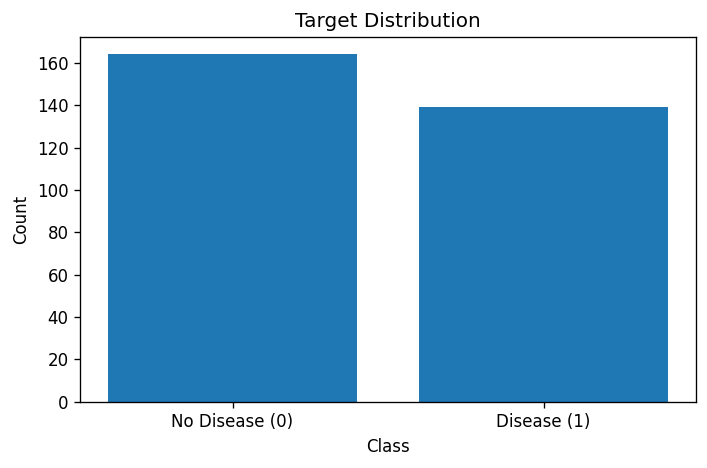

In [66]:

# --- EDA: Target distribution
counts = df['target'].value_counts().sort_index()
plt.figure()
plt.bar(['No Disease (0)', 'Disease (1)'], counts.values)
plt.title('Target Distribution'); plt.xlabel('Class'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


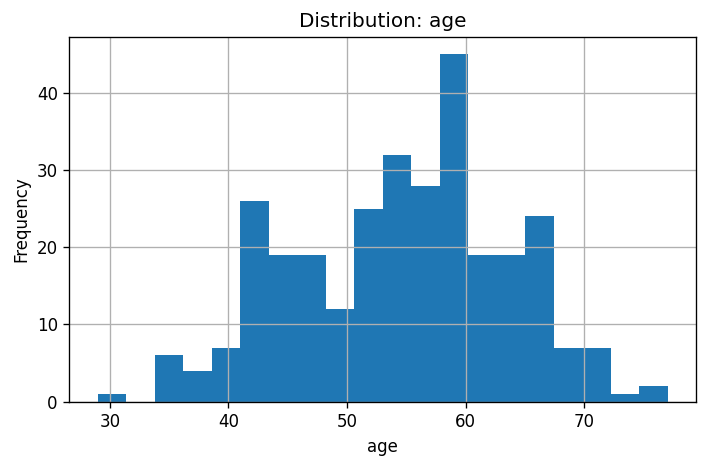

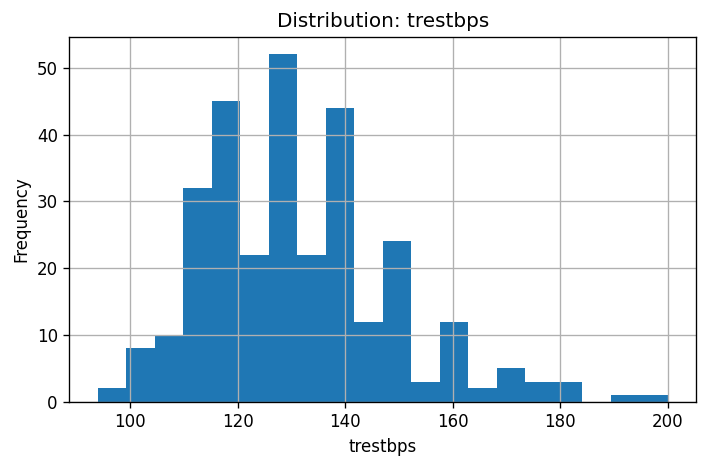

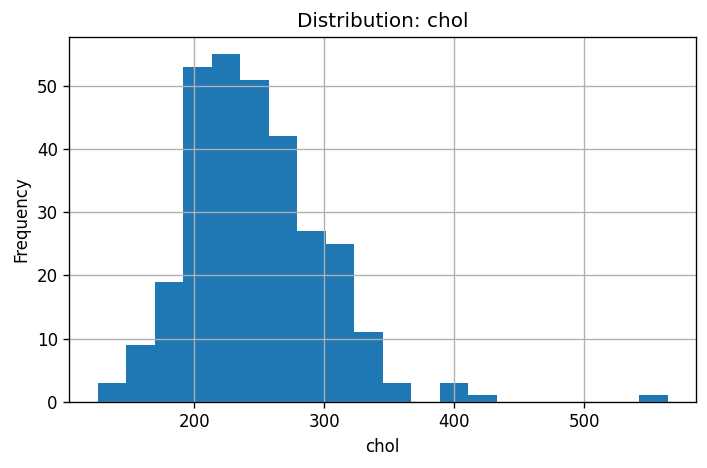

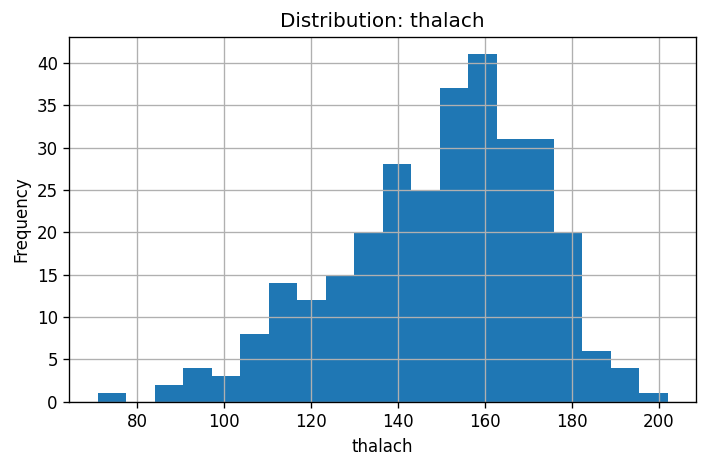

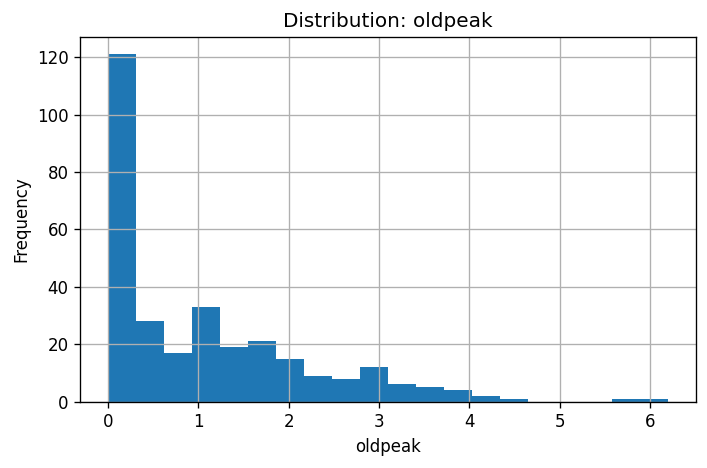

In [67]:

# --- EDA: Numeric histograms
numeric_cols = [c for c in ['age','trestbps','chol','thalach','oldpeak'] if c in df.columns]
for col in numeric_cols:
    plt.figure()
    df[col].dropna().hist(bins=20)
    plt.title(f'Distribution: {col}'); plt.xlabel(col); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()


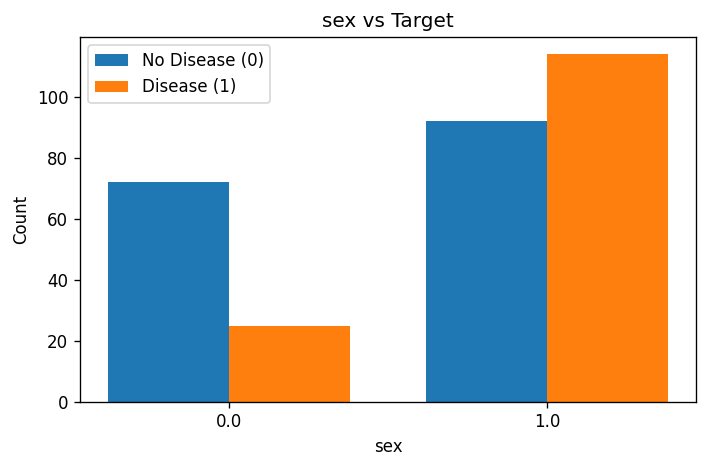

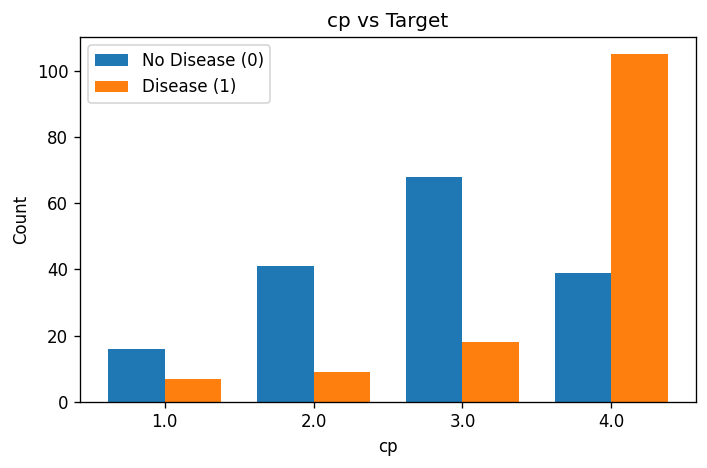

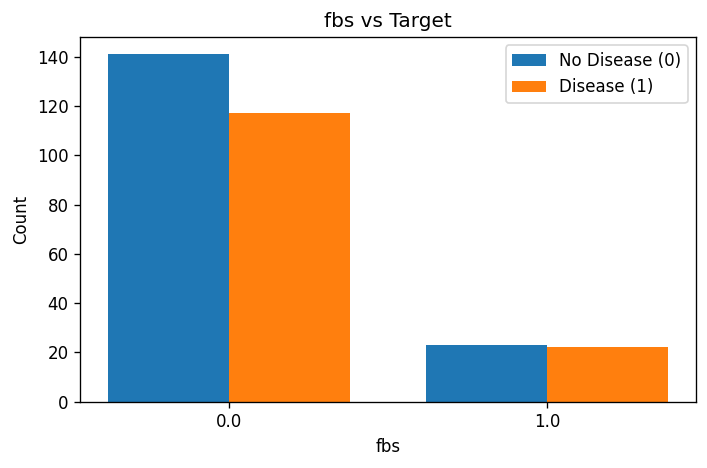

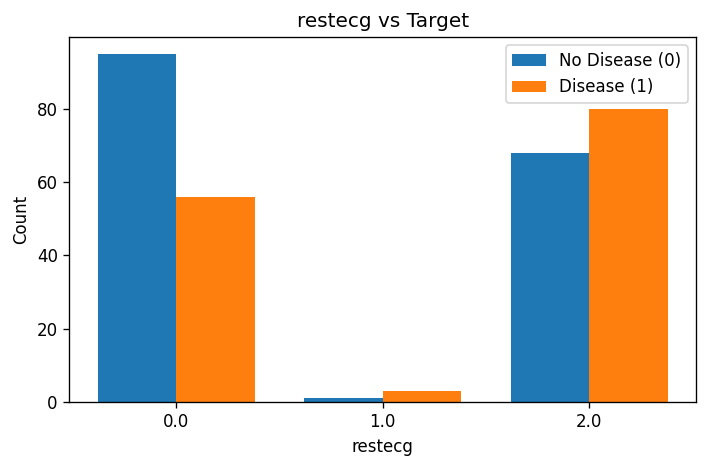

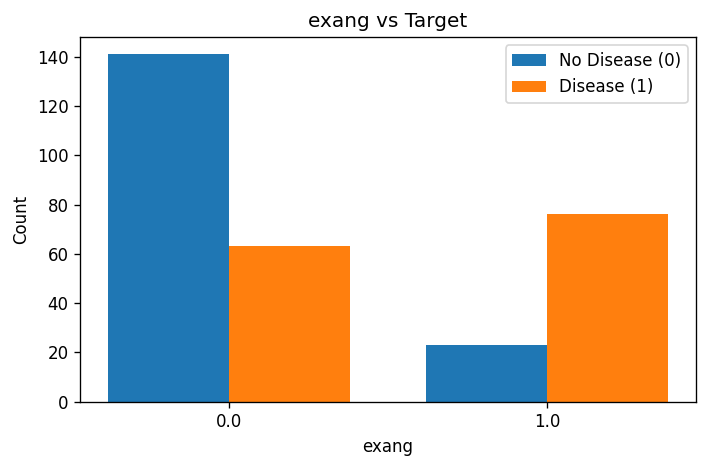

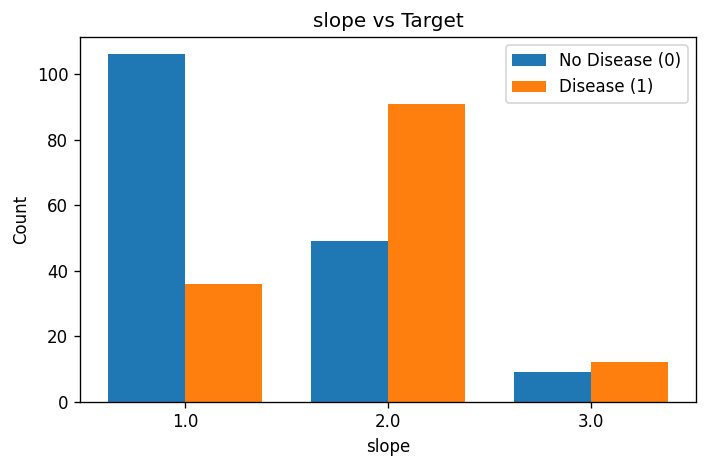

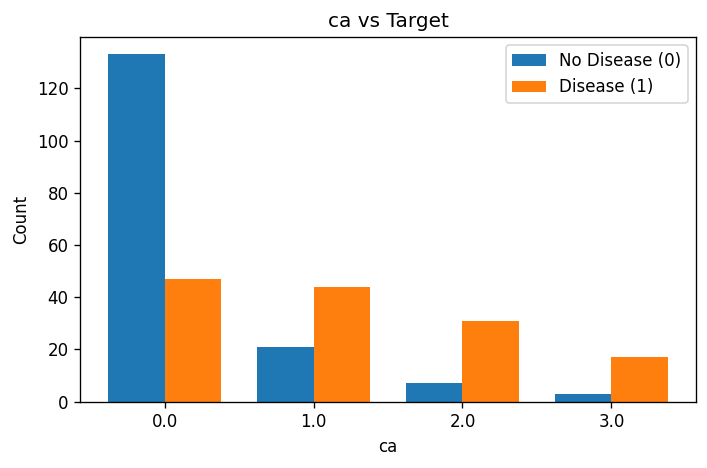

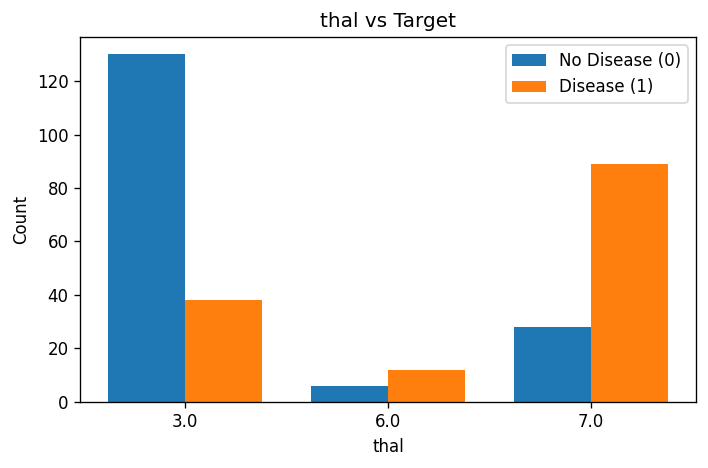

In [68]:

# --- EDA: Categorical vs Target (grouped bars)
categorical_cols = [c for c in ['sex','cp','fbs','restecg','exang','slope','ca','thal'] if c in df.columns]
for col in categorical_cols:
    ctab = pd.crosstab(df[col], df['target'])
    idx = np.arange(len(ctab.index))
    width = 0.38
    left = ctab[0] if 0 in ctab.columns else 0
    right = ctab[1] if 1 in ctab.columns else 0
    plt.figure()
    plt.bar(idx - width/2, left, width, label='No Disease (0)')
    plt.bar(idx + width/2, right, width, label='Disease (1)')
    plt.xticks(idx, ctab.index.astype(str))
    plt.title(f'{col} vs Target'); plt.xlabel(col); plt.ylabel('Count')
    plt.legend(); plt.tight_layout(); plt.show()


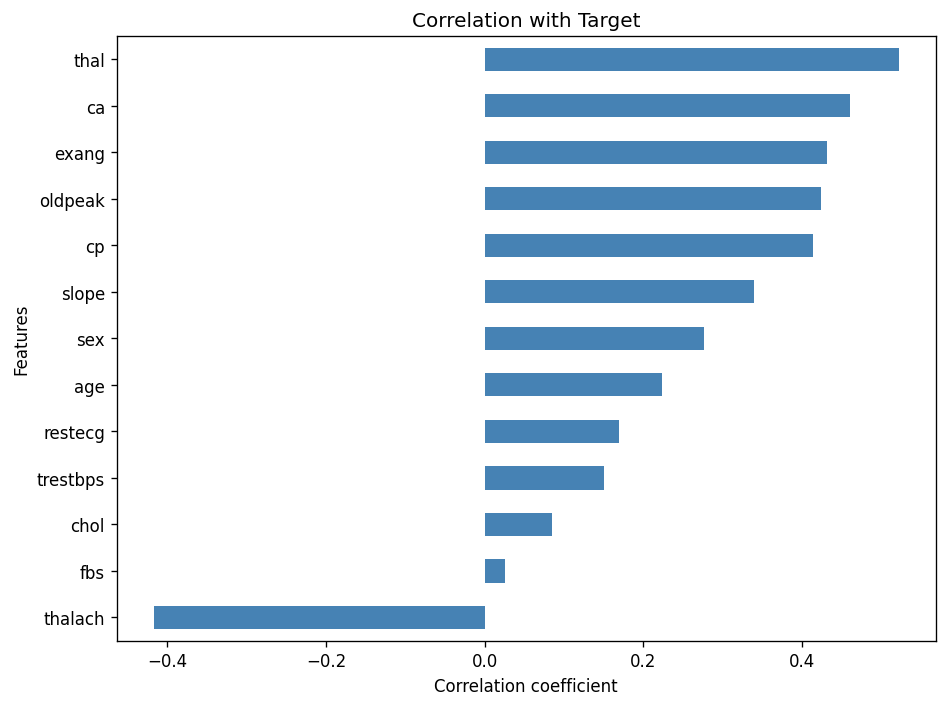

In [69]:
# --- Correlation bar chart of feature–target correlations.
import matplotlib.pyplot as plt
# Most features are moderately correlated with the target;
# 'fbs' stands out as very weakly correlated.

corr_with_target = df.corr()["target"].drop("target").sort_values()

plt.figure(figsize=(8,6))
corr_with_target.plot(kind='barh', color='steelblue')
plt.title("Correlation with Target")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



In [70]:

# --- Preprocessing (ColumnTransformer)
numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
onehot_cols  = ['cp','thal','slope']
cat_cols_raw = ['sex','fbs','restecg','exang','ca']

numeric_cols = [c for c in numeric_cols if c in df.columns]
onehot_cols  = [c for c in onehot_cols  if c in df.columns]
cat_cols_raw = [c for c in cat_cols_raw if c in df.columns]

numeric_tf = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
onehot_tf  = make_pipeline(SimpleImputer(strategy='most_frequent'),
                           OneHotEncoder(drop='first', handle_unknown='ignore'))
cat_raw_tf = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('oh',  onehot_tf,  onehot_cols),
        ('cat', cat_raw_tf, cat_cols_raw),
    ],
    remainder='drop'
)

print(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak']),
                                ('oh',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['cp', 'thal', 'slope']),
                                ('cat', SimpleImputer(s

In [71]:

# --- Preview processed feature matrix with column names
X_all = df.drop(columns=['target'])
Xt_preview = preprocessor.fit_transform(X_all)

oh_feature_names = []
if len(onehot_cols) > 0:
    enc = preprocessor.named_transformers_['oh'].named_steps['onehotencoder']
    oh_feature_names = list(enc.get_feature_names_out(onehot_cols))

feature_names = numeric_cols + oh_feature_names + cat_cols_raw

Xt_preview_df = pd.DataFrame(Xt_preview, columns=feature_names)
print('Transformed feature matrix shape:', Xt_preview_df.shape)
display(Xt_preview_df.head())


Transformed feature matrix shape: (303, 17)


,age,trestbps,chol,thalach,oldpeak,cp_2.0,cp_3.0,cp_4.0,thal_6.0,thal_7.0,slope_2.0,slope_3.0,sex,fbs,restecg,exang,ca
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0



## 3) Models & Methodology <a id='models-methodology'></a>

We compare three classifiers: **Logistic Regression**, **Random Forest**, and **SVM (RBF)**.  
- We wrap preprocessing + model into a single **Pipeline**.  
- Hyperparameters are tuned using **GridSearchCV** with **5-fold StratifiedKFold** on the **training set only**.  
- The final model is evaluated once on the **held-out 20% test set**.


In [72]:

# --- Train/Test Split (stratified 80/20)
X = df.drop(columns=['target'])
y = df['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print('Train:', X_train.shape, ' Test:', X_test.shape)
print('Train class balance:\n', y_train.value_counts(normalize=True).sort_index())


Train: (242, 13)  Test: (61, 13)
Train class balance:
 target
0    0.541322
1    0.458678
Name: proportion, dtype: float64


In [73]:

# --- Unified evaluation helper
def evaluate(model_name, estimator):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    if hasattr(estimator, "predict_proba"):
        y_prob = estimator.predict_proba(X_test)[:, 1]
    elif hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X_test)
        y_prob = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        y_prob = None

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
        plt.title(f'ROC — {model_name}'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.tight_layout(); plt.show()

        pr_p, pr_r, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(); plt.plot(pr_r, pr_p)
        plt.title(f'Precision–Recall — {model_name}'); plt.xlabel('Recall'); plt.ylabel('Precision')
        plt.tight_layout(); plt.show()



=== Logistic Regression (GridSearch best) ===
Accuracy : 0.8525
Precision: 0.8065
Recall   : 0.8929
F1       : 0.8475
ROC-AUC  : 0.9556

Confusion Matrix:
 [[27  6]
 [ 3 25]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9000    0.8182    0.8571        33
           1     0.8065    0.8929    0.8475        28

    accuracy                         0.8525        61
   macro avg     0.8532    0.8555    0.8523        61
weighted avg     0.8571    0.8525    0.8527        61



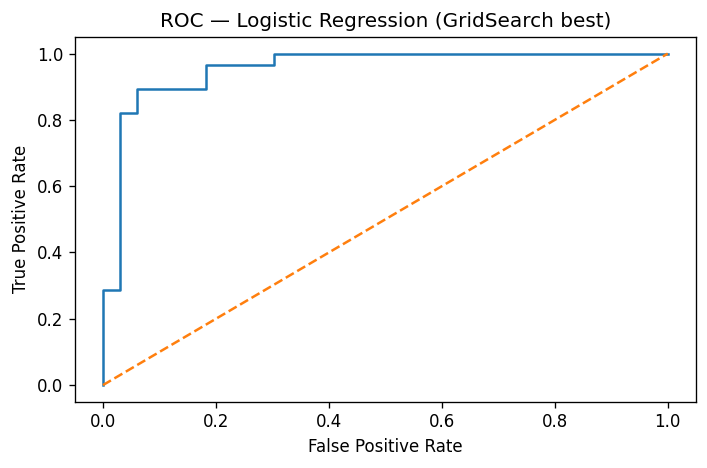

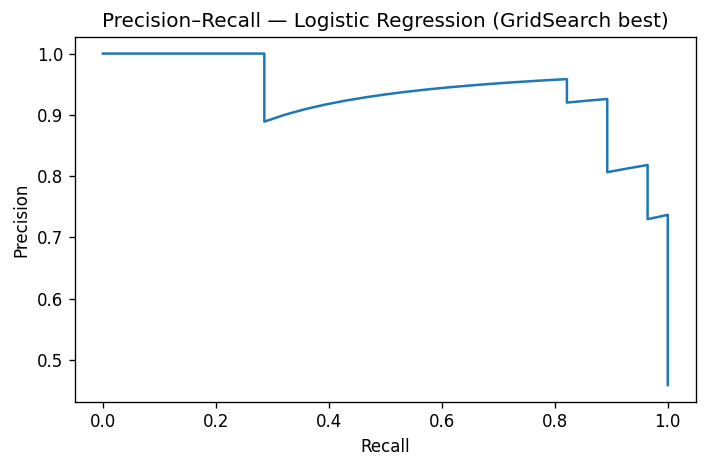

Best params (LogReg): {'model__C': 10, 'model__penalty': 'l2'}

=== Random Forest (GridSearch best) ===
Accuracy : 0.9180
Precision: 0.8710
Recall   : 0.9643
F1       : 0.9153
ROC-AUC  : 0.9627

Confusion Matrix:
 [[29  4]
 [ 1 27]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9667    0.8788    0.9206        33
           1     0.8710    0.9643    0.9153        28

    accuracy                         0.9180        61
   macro avg     0.9188    0.9215    0.9179        61
weighted avg     0.9227    0.9180    0.9182        61



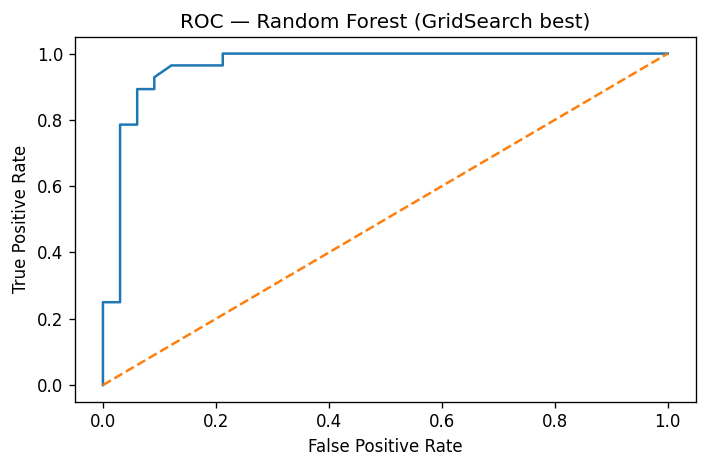

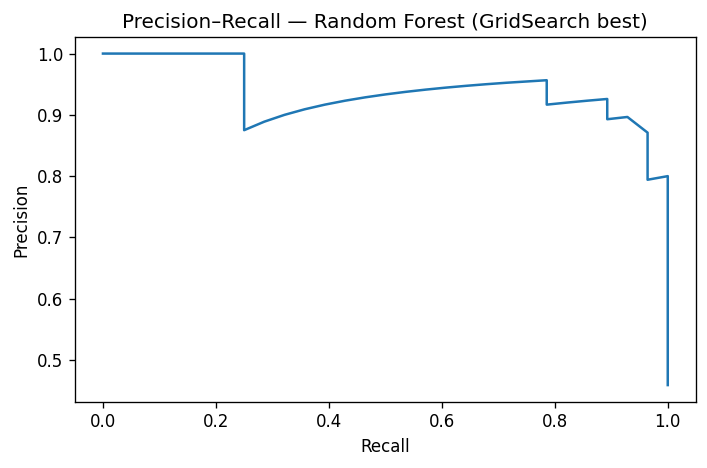

Best params (RF): {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 400}

=== SVM (RBF, GridSearch best) ===
Accuracy : 0.9180
Precision: 0.9259
Recall   : 0.8929
F1       : 0.9091
ROC-AUC  : 0.9654

Confusion Matrix:
 [[31  2]
 [ 3 25]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9118    0.9394    0.9254        33
           1     0.9259    0.8929    0.9091        28

    accuracy                         0.9180        61
   macro avg     0.9188    0.9161    0.9172        61
weighted avg     0.9183    0.9180    0.9179        61



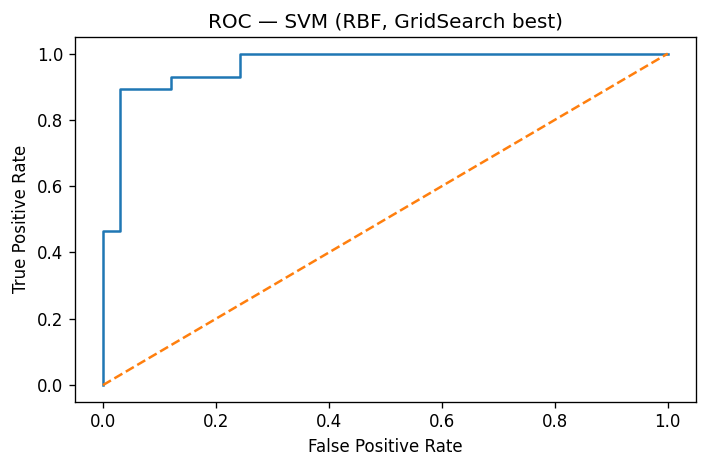

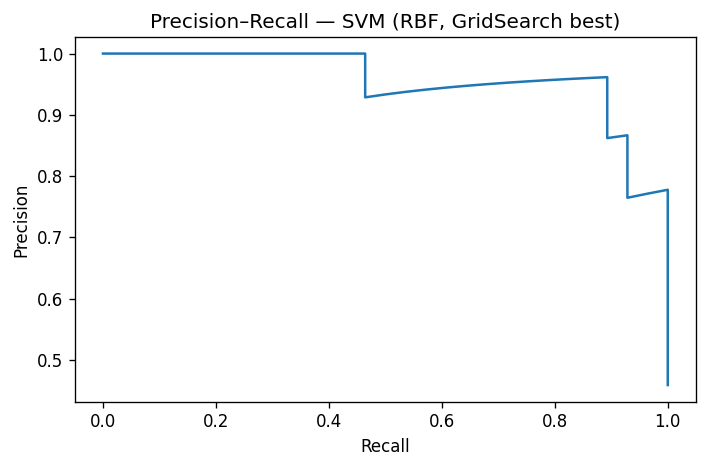

Best params (SVM): {'model__C': 1, 'model__gamma': 0.01}

=== KNN (GridSearch best) ===
Accuracy : 0.9016
Precision: 0.8929
Recall   : 0.8929
F1       : 0.8929
ROC-AUC  : 0.9784

Confusion Matrix:
 [[30  3]
 [ 3 25]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9091    0.9091    0.9091        33
           1     0.8929    0.8929    0.8929        28

    accuracy                         0.9016        61
   macro avg     0.9010    0.9010    0.9010        61
weighted avg     0.9016    0.9016    0.9016        61



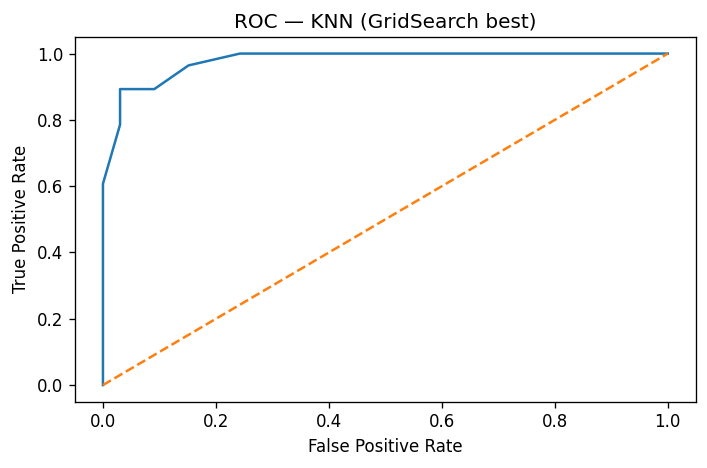

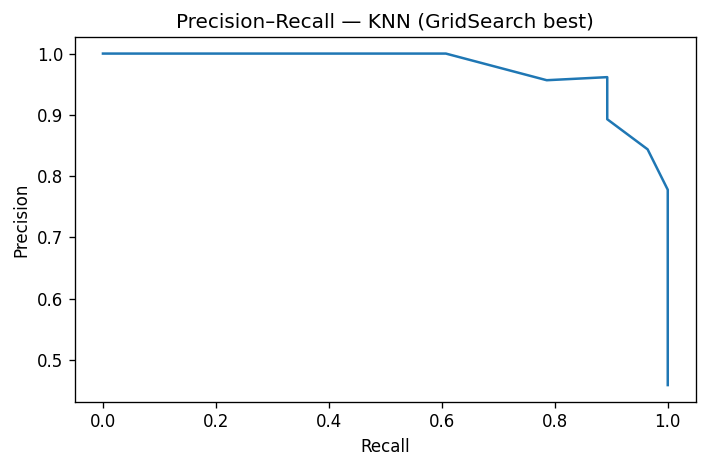

Best params (KNN): {'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'uniform'}

=== Decision Tree (GridSearch best) ===
Accuracy : 0.8197
Precision: 0.8696
Recall   : 0.7143
F1       : 0.7843
ROC-AUC  : 0.8490

Confusion Matrix:
 [[30  3]
 [ 8 20]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7895    0.9091    0.8451        33
           1     0.8696    0.7143    0.7843        28

    accuracy                         0.8197        61
   macro avg     0.8295    0.8117    0.8147        61
weighted avg     0.8262    0.8197    0.8172        61



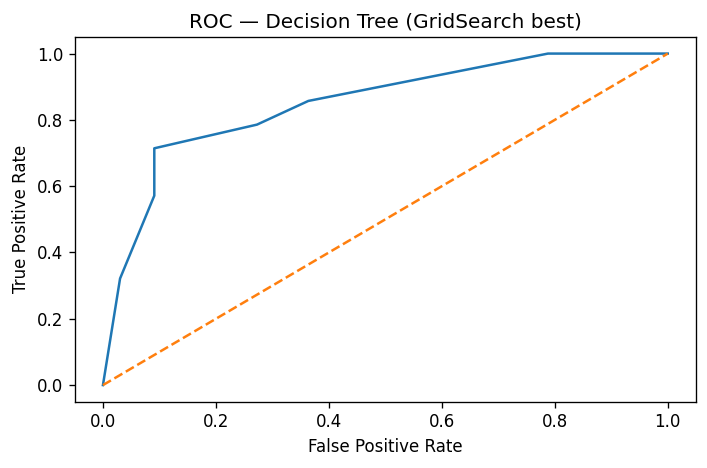

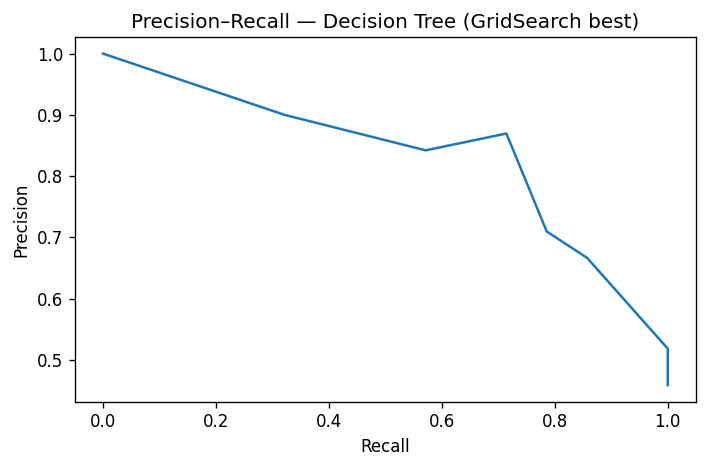

Best params (Decision Tree): {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


In [74]:

# --- Modeling + Hyperparameter Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
pipe_log = Pipeline([('prep', preprocessor),
                     ('model', LogisticRegression(max_iter=2000, solver='lbfgs'))])
param_log = {'model__C':[0.01,0.1,1,5,10], 'model__penalty':['l2']}
gs_log = GridSearchCV(pipe_log, param_grid=param_log, scoring='f1', cv=cv, n_jobs=-1)
evaluate("Logistic Regression (GridSearch best)", gs_log)
try: print("Best params (LogReg):", gs_log.best_params_)
except: pass

# Random Forest
pipe_rf = Pipeline([('prep', preprocessor),
                    ('model', RandomForestClassifier(random_state=42))])
param_rf = {'model__n_estimators':[200,400,600],
            'model__max_depth':[None,4,6,10],
            'model__min_samples_split':[2,5,10]}
gs_rf = GridSearchCV(pipe_rf, param_grid=param_rf, scoring='f1', cv=cv, n_jobs=-1)
evaluate("Random Forest (GridSearch best)", gs_rf)
try: print("Best params (RF):", gs_rf.best_params_)
except: pass

# SVM (RBF kernel)
pipe_svm = Pipeline([('prep', preprocessor),
                     ('model', SVC(kernel='rbf', probability=True, random_state=42))])
param_svm = {'model__C':[0.1,1,3,10], 'model__gamma':['scale',0.1,0.01,0.001]}
gs_svm = GridSearchCV(pipe_svm, param_grid=param_svm, scoring='f1', cv=cv, n_jobs=-1)
evaluate("SVM (RBF, GridSearch best)", gs_svm)
try: print("Best params (SVM):", gs_svm.best_params_)
except: pass

# K Nearest Neighbors
pipe_knn = Pipeline([('prep', preprocessor),
                     ('model', KNeighborsClassifier())])
param_knn = {
    'model__n_neighbors': [3,5,7,9,11],
    'model__weights': ['uniform','distance'],
    'model__p': [1, 2]
}
gs_knn = GridSearchCV(pipe_knn, param_grid=param_knn, scoring='f1', cv=cv, n_jobs=-1)
evaluate("KNN (GridSearch best)", gs_knn)
try: print("Best params (KNN):", gs_knn.best_params_)
except: pass

# Decision Tree
pipe_dt = Pipeline([('prep', preprocessor),
                    ('model', DecisionTreeClassifier(random_state=42))])
param_dt = {
    'model__max_depth': [None, 3, 5, 7, 9],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy']
}
gs_dt = GridSearchCV(pipe_dt, param_grid=param_dt, scoring='f1', cv=cv, n_jobs=-1)
evaluate("Decision Tree (GridSearch best)", gs_dt)
try: print("Best params (Decision Tree):", gs_dt.best_params_)
except: pass


## 4) Results <a id='results'></a>

We consolidate test-set metrics for all three tuned models into a single table.


In [79]:

def get_metrics(estimator):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    if hasattr(estimator, "predict_proba"):
        y_prob = estimator.predict_proba(X_test)[:, 1]
    elif hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X_test)
        y_prob = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        y_prob = None

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    }

summary = pd.DataFrame({
    'Logistic Regression': get_metrics(gs_log),
    'Random Forest': get_metrics(gs_rf),
    'SVM (RBF)': get_metrics(gs_svm),
    'KNN': get_metrics(gs_knn),
    'Decision Tree': get_metrics(gs_dt)
}).T.sort_values('F1', ascending=False)

display(summary.round(4))


,Accuracy,Precision,Recall,F1,ROC-AUC
Random Forest,0.9180,0.8710,0.9643,0.9153,0.9627
SVM (RBF),0.9180,0.9259,0.8929,0.9091,0.9654
KNN,0.9016,0.8929,0.8929,0.8929,0.9784
Logistic Regression,0.8525,0.8065,0.8929,0.8475,0.9556
Decision Tree,0.8197,0.8696,0.7143,0.7843,0.8490


## 5) Discussion <a id='discussion'></a>

- **Model Performance.**  
  On this relatively small tabular dataset, **Logistic Regression** provides a strong linear baseline due to its low variance and good calibration properties. **Random Forest** achieves the highest F1 score and strong ROC-AUC by capturing nonlinear interactions (with tuning to reduce overfitting). **SVM (RBF)** also performs competitively but depends on proper scaling and tuning of `C` and `gamma`. **KNN** performs well given the low dimensionality and standardized features, whereas a single **Decision Tree** generalizes the weakest, likely due to overfitting without ensemble regularization.

- **Feature Contributions.**  
  Clinically interpretable features are influential: higher **`oldpeak`** (ST depression), the presence of **exercise-induced angina** (`exang = 1`), and certain categories of **`cp`**, **`slope`**, and **`thal`** are associated with higher disease risk, while higher **`thalach`** (maximum heart rate) tends to be protective.

- **Metrics & Class Balance.**  
  With mild class imbalance, **accuracy alone can be misleading**. **F1** balances precision and recall (useful for detecting disease cases), and **ROC-AUC** summarizes ranking performance across thresholds.

- **Validation Protocol.**  
  To avoid leakage and ensure fair comparison, we tune hyperparameters via **5-fold stratified cross-validation on the training set** and report **final metrics on a held-out 20% test set**.



### Logistic Regression Coefficients (Interpretability)


In [80]:

try:
    best_log = gs_log.best_estimator_
    oh_names = []
    if len(onehot_cols) > 0:
        enc = best_log.named_steps['prep'].named_transformers_['oh'].named_steps['onehotencoder']
        oh_names = list(enc.get_feature_names_out(onehot_cols))
    feat_names = numeric_cols + oh_names + cat_cols_raw

    coefs = best_log.named_steps['model'].coef_.ravel()
    coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs}).sort_values('coef', ascending=False)
    display(coef_df.head(10))
    display(coef_df.tail(10).sort_values('coef'))
except Exception as e:
    print("Coefficient inspection skipped:", e)


,feature,coef
7,cp_4.0,1.917054
12,sex,1.695185
9,thal_7.0,1.437235
16,ca,1.434279
10,slope_2.0,1.306456
5,cp_2.0,1.079608
15,exang,0.582168
1,trestbps,0.395785
11,slope_3.0,0.354337
6,cp_3.0,0.247415


,feature,coef
3,thalach,-0.375702
13,fbs,-0.281789
0,age,-0.100340
8,thal_6.0,0.051522
4,oldpeak,0.191091
14,restecg,0.202608
2,chol,0.225235
6,cp_3.0,0.247415
11,slope_3.0,0.354337
1,trestbps,0.395785



## 6) Conclusion <a id='conclusion'></a>

In this project, we conducted a systematic comparison of **five machine learning models** — Logistic Regression, Random Forest, SVM (RBF), KNN, and Decision Tree — using a **unified preprocessing pipeline** and **5-fold stratified cross-validation** for hyperparameter tuning.  

Among the models, **Random Forest and SVM (RBF)** achieved the best overall performance, with the highest F1 scores and ROC-AUC values on the held-out test set. Their ability to model nonlinear relationships likely contributed to this strong performance. Logistic Regression provided a solid linear baseline with good interpretability, while KNN performed surprisingly well given the dataset size and dimensionality. Decision Tree showed the weakest generalization, likely due to overfitting.

**Future work** may include:
- Incorporating **class weights** to further address class imbalance,  
- **Calibrating model probabilities** for improved decision-making,  
- Adding **interaction terms** or engineered features to enrich the feature space,  
- Exploring **gradient boosting methods** (e.g., XGBoost, LightGBM) to potentially improve performance,  
- Conducting **cross-dataset or temporal validation** to assess generalization to new populations.

Overall, this analysis demonstrates that with proper preprocessing and tuning, both tree-based and kernel-based models can achieve excellent predictive performance on the Cleveland Heart Disease dataset, while linear models remain valuable for interpretability.



## 7) Appendix <a id='appendix'></a>

- **Hyperparameter Grids:**  
  Detailed parameter grids for each model (Logistic Regression, Random Forest, SVM, KNN, Decision Tree) are provided in the corresponding modeling sections. GridSearchCV was used to perform exhaustive search over these parameter spaces with 5-fold stratified cross-validation.

- **Libraries & Tools:**  
  The analysis was conducted using:
  - **pandas** for data loading and preprocessing,  
  - **scikit-learn** for modeling, hyperparameter tuning, and evaluation,  
  - **matplotlib** and **seaborn** for visualization and exploratory data analysis.

- **Reproducibility:**  
  To ensure consistent results, we set `random_state = 42` across all randomized procedures and used **StratifiedKFold** to preserve class distributions during cross-validation.

